# Etape 1 - Exploration des données (y compris préprocessing)

In [1]:
# Import librairies
import csv
import pandas as pd
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import warnings


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from utils_text_processing import *

c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:75: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packa

gensim version: 4.3.0
tensorflow version: 2.10.0
Num GPUs Available:  0
is tf built with cuda: False


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


USE model %s loaded


In [2]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Autorisation pour la visualisation par pyLDAvis
pyLDAvis.enable_notebook()

In [4]:
# Paramètres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)
dpi = 300

In [5]:
# Import des données
#data = pd.read_csv("../data/export.dsv", sep="\t", encoding='latin-1')

In [6]:
# Import des données
with open('../data/export.dsv', 'r', newline='', encoding="latin") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t',)
    data=list(csv_reader) 

In [7]:
# Verification du format des données
df = pd.DataFrame(data[1:], columns=data[0]+["A", "B"])
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 89434 lignes et  7 colonnes


In [8]:
# Visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None


In [9]:
# Recherche des lignes mal formattées
data_to_check = df[(~df["A"].isna()) | (~df["B"].isna())]
print("Nombre d'ouvrages avec soucis d'importation :", data_to_check.shape)
data_to_check

Nombre d'ouvrages avec soucis d'importation : (18, 7)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
12634,130654965,L'individu contre l'État,"La 4e de couverture indique :""","a Herbert Spencer (1820-1903), philosophe, éco...",Libéralisme;Libéralisme,320.510 941,None
14569,145536599,Thèbes aux 101 portes : mélanges à la mémoire ...,La nécropole thébaine attire archéologues et a...,architecture des chapelles funéraires et de le...,"arrêt sur images"", abordant par ailleurs la co...",Religion égyptienne;Religions;Égyptien ancien ...,932-933
20334,168619016,Le Paris des années 1920 : avec Kiki de Montpa...,"Paris, 1918-1928, ce sont les années folles. I...",avant- garde. Dadaïstes et surréalistes s'y di...,Artistes;Artistes et modèles;Vie intellectuell...,700,None
20654,169298116,La salope éthique : guide pratique pour des r...,,"a En 1997, un objet littéraire non identifié e...",Amour libre;Liberté sexuelle;Relations amoureuses,306.7,None
32591,193458209,Principes de marketing,"La quatrième de couv. indique : ""Écrit par les...",version française : des modules d'apprentissa...,Marketing,658.8,None
32974,193928604,Japanese,Guide de conversation Japonais pour anglophones,tous niveaux Quelques jours à Tokyo ou sur un...,Japonais (langue) -- Vocabulaires et manuels d...,495.683 441,None
32975,193928612,German,Guide de conversation allemand pour anglophones,tous niveaux. Berlin Munich ou peut-être Vien...,Allemand (langue) -- Vocabulaires et manuels d...,438.34,None
33309,194347818,Macroéconomie,"La 4e de couverture indique : ""Véritable livre...","version française, lui aussi augmenté, vous a...",Macroéconomie -- Manuels d'enseignement supéri...,339,None
50885,231039786,Petites conversations sur les violences : paro...,,"a En 2018, en France, les violences répétées s...",Femmes victimes de violence -- Psychologie;Vio...,362.829 2,None
58788,23698134X,"Haute agora : [exposition, Paris, Pavillon de ...","Haute Agora, étude menée par larchitecte Jean...",Ce travail se présente comme une réponse aux t...,Christianisme et franc-maçonnerie,366.1,None


In [10]:
# Export des données à vérifier
data_to_check.to_csv("data_to_check_V2.csv", index=0, encoding="latin-1")

In [11]:
# On ne garde que les données correctement importées
df = df.drop(index = data_to_check.index)
df

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None
...,...,...,...,...,...,...,...
89429,268339252,Le sentiment d'humanité : manifeste pour une f...,"« Mon enfant, ma fille, qu'est-ce qu'e^tre hum...",Humanité;Réalisation de soi,128,None,None
89430,268363072,La saga des trois petits pois,"Trois pois, Réal, Jean-Jacques et Donald, ont ...",Aliments -- Ouvrages pour la jeunesse;Pois (lé...,843/.914 D814s,None,None
89431,268365113,Droit de la représentation du personnel,"Présentation de l'éditeur : ""Le droit de la re...",Représentation du personnel,344.018,None,None
89432,268365334,Droit pénal social : droit pénal du travail et...,"Depuis deux siècles, la conjugaison de l'essor...",Droit pénal;Sécurité sociale -- Droit -- Dispo...,345.44,None,None


In [12]:
# Verification que les colonnes A et B sont vides
print("Colonne A: ", all(df["A"].isna()))
print("Colonne B: ", all(df["B"].isna()))

Colonne A:  True
Colonne B:  True


In [13]:
# Suppression des colonnes vides
df.dropna(axis=1, inplace=True)
df.shape

(89416, 5)

In [14]:
# Echantillon de visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [15]:
# Vérification du format des colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89433
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PPN     89416 non-null  object
 1   TITRE   89416 non-null  object
 2   RESUME  89416 non-null  object
 3   RAMEAU  89416 non-null  object
 4   DEWEY   89416 non-null  object
dtypes: object(5)
memory usage: 4.1+ MB


## Exploration des mots-clé RAMEAU

In [16]:
df.loc[1:10, "RAMEAU"]

1             Complexe de castration;Psychanalyse;Rêves
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Agglomérations urbaines;Aménagement du territo...
7                     Tarots (cartes à jouer) -- Contes
8     Allégorie de la caverne;Différences entre sexe...
9     Attachement;Mères et nourrissons;Personnalité ...
10                  Philosophes;Philosophie et sciences
Name: RAMEAU, dtype: object

In [57]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU
df["test_tiret"] = df["RAMEAU"].apply(lambda x: True if re.search(' -- ', x) else False)
df.loc[df["test_tiret"]==True, ["PPN", "RAMEAU"]]

,PPN,RAMEAU
4,000026352,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...
11,000049719,Civilisation -- Histoire
18,000062995,Professeurs des écoles -- Formation;Écoles nor...
...,...,...
89420,268319014,Art chrétien -- Peinture
89423,268334846,Préparation au mariage -- Église catholique
89430,268363072,Aliments -- Ouvrages pour la jeunesse;Pois (lé...
89432,268365334,Droit pénal;Sécurité sociale -- Droit -- Dispo...


In [105]:
df["rameau_list"] = df["RAMEAU"].apply(lambda x: x.split(';')).apply(lambda x: ",".join(set(x)))
df.loc[1:10, "rameau_list"]

1             Rêves,Complexe de castration,Psychanalyse
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Aménagement du territoire,Relations villes-cam...
7                     Tarots (cartes à jouer) -- Contes
8     Féminité,Allégorie de la caverne,Différences e...
9     Attachement,Personnalité -- Chez l'enfant,Mère...
10                  Philosophes,Philosophie et sciences
Name: rameau_list, dtype: object

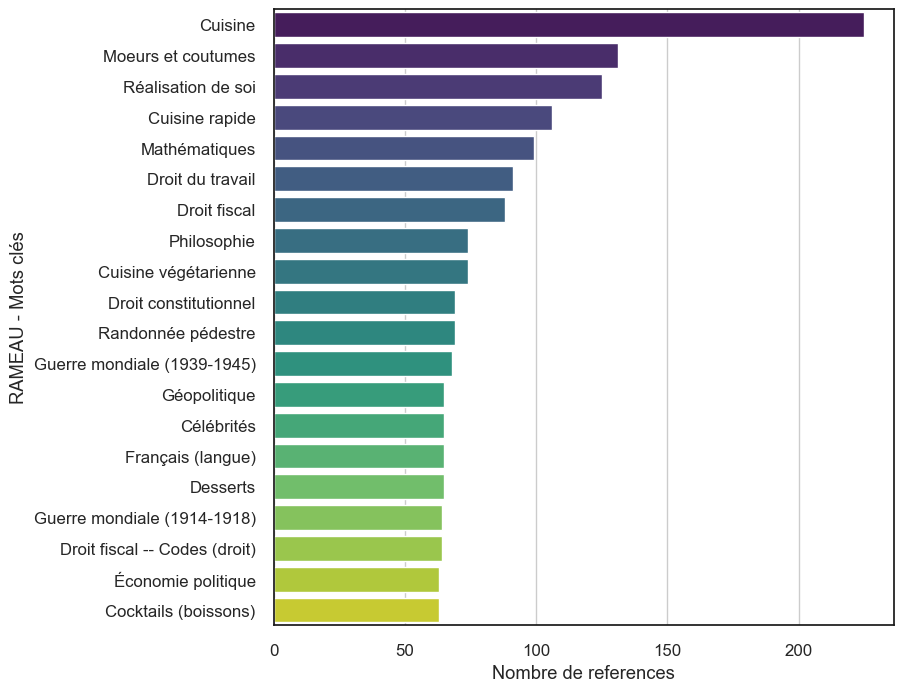

In [106]:
plot_barplot_of_tags(
    tags_list=df.loc[:, 'rameau_list'],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords.png',
    figsize=(8, 8))

In [118]:
idx = 1
print(df.loc[idx, "rameau_list"])
a = [item.split(" -- ")[0] for item in df.loc[idx, "rameau_list"].split(",")]
a

Rêves,Complexe de castration,Psychanalyse


['Rêves', 'Complexe de castration', 'Psychanalyse']

In [120]:
type(df.loc[idx, "rameau_list"])

str

In [121]:
df.loc[idx, "rameau_list"].split(',')

['Rêves', 'Complexe de castration', 'Psychanalyse']

In [76]:
df["rameau_list"]

0        Culture populaire,  Politique culturelle,  Dif...
1            Complexe de castration,  Rêves,  Psychanalyse
2                                                  Culture
3                                           Structuralisme
4        Science-fiction américaine -- Traductions fran...
                               ...                        
89429                         Réalisation de soi, Humanité
89430    Aliments -- Ouvrages pour la jeunesse,  Pois (...
89431                          Représentation du personnel
89432     Sécurité sociale -- Droit -- Dispositions pén...
89433    Fraude scientifique -- Lutte contre,  Médecins...
Name: rameau_list, Length: 89416, dtype: object

In [128]:
for i in df.index:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [157]:
# Mettre à plat TOUS les mots clé
for i in df.index:
    ram_list = df.loc[i, "rameau_list"]
    if re.search(" -- ", ram_list):
        df.loc[i, "rameau_list_concepts_majeurs"] = ",".join([item.split(" -- ")[0] for item in ram_list.split(",")])
    else:
        df.loc[i, "rameau_list_concepts_majeurs"] = ram_list

In [158]:
df["rameau_list_concepts_majeurs"] 

0        Politique culturelle,Culture populaire,Diffusi...
1                Rêves,Complexe de castration,Psychanalyse
2                                                  Culture
3                                           Structuralisme
4                               Science-fiction américaine
                               ...                        
89429                          Réalisation de soi,Humanité
89430                              Aliments,Pois (légumes)
89431                          Représentation du personnel
89432                         Droit pénal,Sécurité sociale
89433                         Fraude scientifique,Médecins
Name: rameau_list_concepts_majeurs, Length: 89416, dtype: object

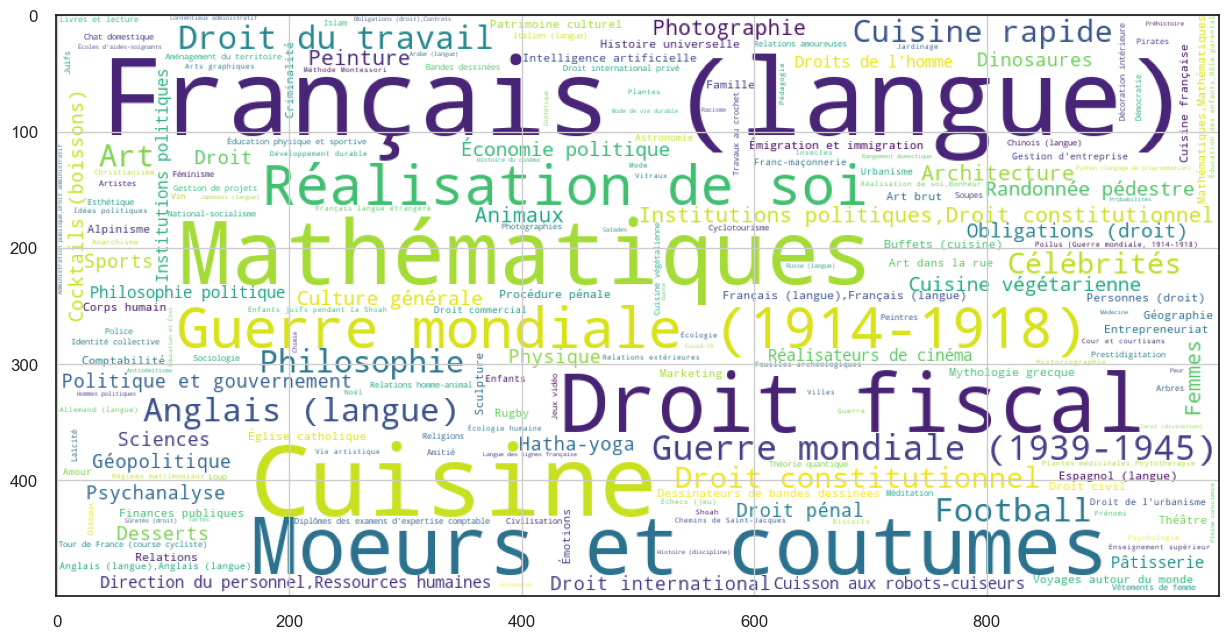

In [159]:
rameau_list_concepts_majeurs_dict = df['rameau_list_concepts_majeurs'].value_counts().to_dict()
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(rameau_list_concepts_majeurs_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

In [19]:
# Mettre à plat TOUS les mots clé
df["rameau_list_unstack"] = df["RAMEAU"].apply(lambda x: re.split(r';| -- ', x)).apply(lambda x: ", ".join(set(x)))
df.loc[1:10, "rameau_list_unstack"]

1           Rêves, Complexe de castration, Psychanalyse
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine, Traductions frança...
5                                          Photographie
6     Aménagement du territoire, Relations villes-ca...
7                       Contes, Tarots (cartes à jouer)
8     Féminité, Allégorie de la caverne, Différences...
9     Personnalité, Attachement, Chez l'enfant, Mère...
10                 Philosophes, Philosophie et sciences
Name: rameau_list_unstack, dtype: object

In [20]:
text = df['rameau_list_unstack'].value_counts().to_dict()
text

{'Cuisine': 225,
 'Moeurs et coutumes': 131,
 'Réalisation de soi': 125,
 'Cuisine rapide': 106,
 'Mathématiques': 99,
 'Droit du travail': 91,
 'Droit fiscal': 88,
 'Philosophie': 74,
 'Cuisine végétarienne': 74,
 'Droit constitutionnel': 69,
 'Guerre mondiale (1939-1945)': 69,
 'Randonnée pédestre': 69,
 'Français (langue)': 66,
 'Géopolitique': 65,
 'Desserts': 65,
 'Célébrités': 65,
 'Codes (droit), Droit fiscal': 64,
 'Guerre mondiale (1914-1918)': 64,
 'Économie politique': 63,
 'Cocktails (boissons)': 63,
 'Institutions politiques, Droit constitutionnel': 61,
 'Cuisson aux robots-cuiseurs': 59,
 'Hatha-yoga': 58,
 'Peinture': 58,
 'Direction du personnel, Ressources humaines': 57,
 'Art': 53,
 'Dinosaures': 52,
 'Psychanalyse': 52,
 'Photographie': 52,
 'Pâtisserie': 51,
 'Obligations (droit)': 49,
 'Culture générale': 49,
 'Cuisine française': 48,
 'Philosophie politique': 48,
 'Alpinisme': 46,
 'Dessinateurs de bandes dessinées': 46,
 'Femmes': 45,
 'Buffets (cuisine)': 45,
 '

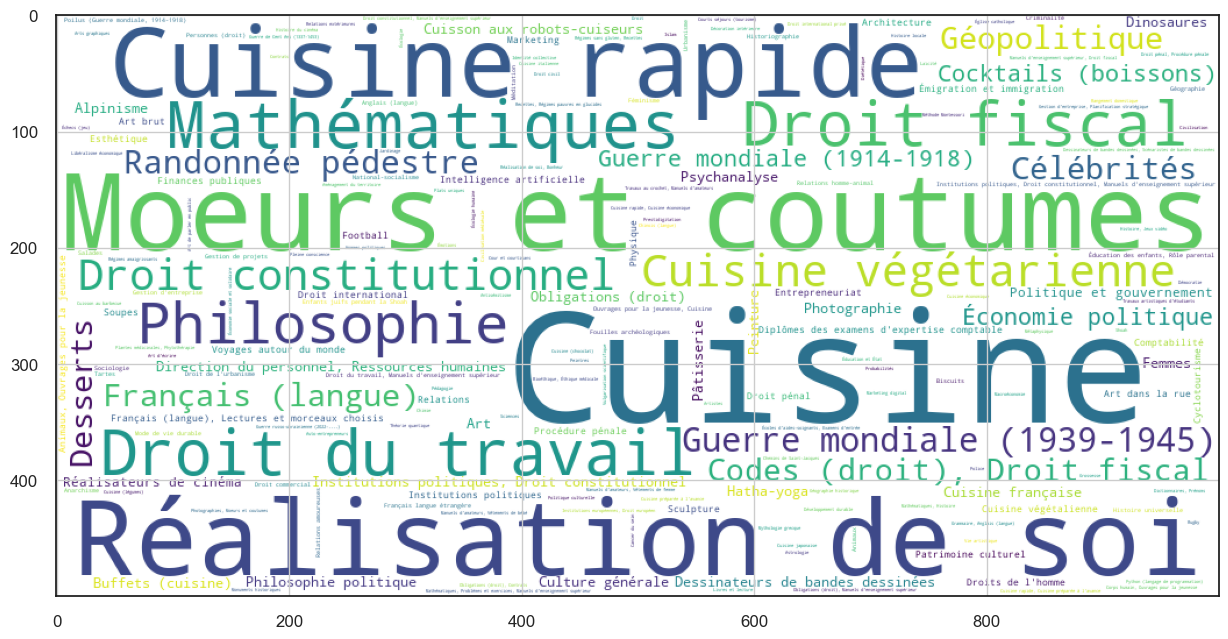

In [21]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

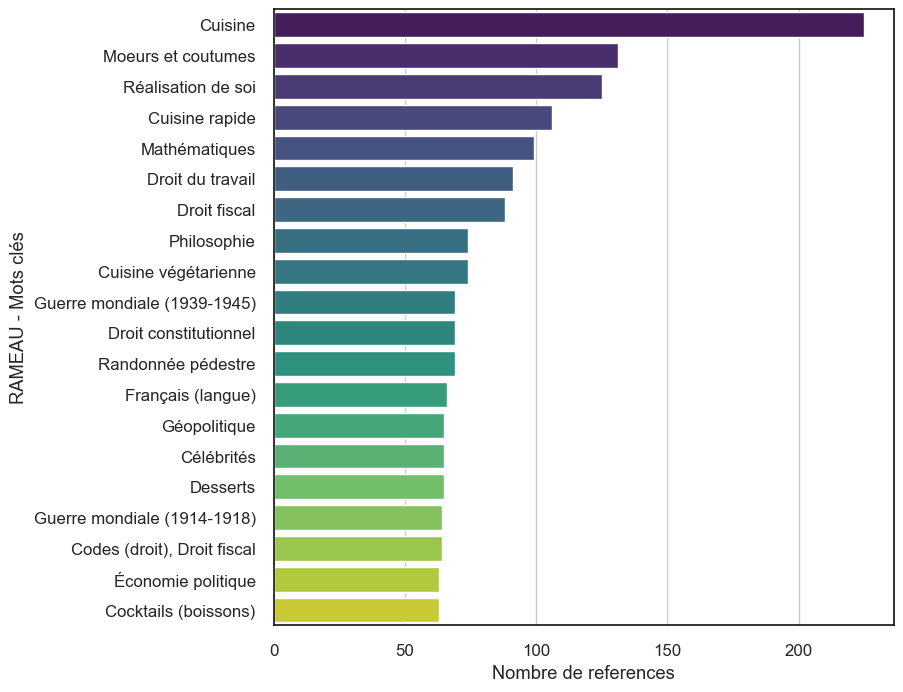

In [22]:
plot_barplot_of_tags(
    tags_list=df.loc[:, 'rameau_list_unstack'],
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords_unstack.png',
    figsize=(8, 8))

## Exploration des titres

In [23]:
list(set(stopwords.words("french")))

['fusse',
 'un',
 'nous',
 'elle',
 'fûmes',
 'moi',
 'ai',
 'ils',
 'avons',
 'fus',
 'fussions',
 'pas',
 'aurais',
 'sur',
 'y',
 'sa',
 'auriez',
 'tu',
 'des',
 'eussiez',
 'as',
 'ait',
 'eussions',
 'eûmes',
 'serons',
 'serais',
 'furent',
 'une',
 'aies',
 'avait',
 'eues',
 'sera',
 'eusse',
 'vous',
 'ou',
 'il',
 'en',
 'eus',
 'mes',
 'aux',
 'es',
 'au',
 'aient',
 'eut',
 'votre',
 'étantes',
 'à',
 'seraient',
 'même',
 't',
 'pour',
 'ce',
 'ont',
 'le',
 'serez',
 'seriez',
 'lui',
 'l',
 'fut',
 'seras',
 'ayons',
 'est',
 'ne',
 'étant',
 'eusses',
 'ayantes',
 'avec',
 'soyons',
 's',
 'serai',
 'on',
 'se',
 'aviez',
 'étaient',
 'étés',
 'fussent',
 'notre',
 'dans',
 'leur',
 'sont',
 'vos',
 'fût',
 'j',
 'étante',
 'sommes',
 'étais',
 'étiez',
 'eu',
 'aie',
 'm',
 'auraient',
 'aurait',
 'ma',
 'qui',
 'ayant',
 'était',
 'de',
 'aurons',
 'aurai',
 'et',
 'les',
 'été',
 'ayante',
 'd',
 'eue',
 'que',
 'soit',
 'étions',
 'la',
 'mais',
 'nos',
 'du',
 'au

In [24]:
# Test function
idx = 1045
text = df.loc[idx, 'TITRE']
print(text)

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie


In [25]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du"
]


preprocess_text(
        text, add_words,
        numeric=True, stopw=True,
        stem=False, lem=True)

'éloge folie adage colloques réflexions éducation religion guerre philosophie'

In [26]:
idx = 4985
df['TITRE_processed'] = df['TITRE'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

# Exemple
print("Titre brut: \n", df.loc[idx, 'TITRE'])
print("\nTitre après processing :\n", df.loc[idx, 'TITRE_processed'])

Titre brut: 
 Les barons du caoutchouc

Titre après processing :
 baron caoutchouc


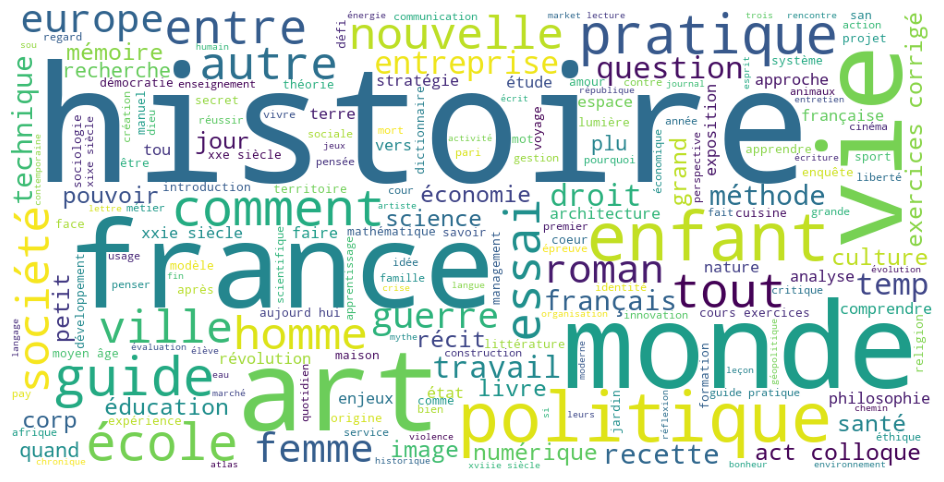

In [58]:
plot_wordcloud(df['TITRE_processed'])

### Exploration des topics (pyLDAvis)

In [32]:
# Vectorization
feature = 'TITRE_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95)
cv_transform = model.fit_transform(df[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (89416, 300)


In [33]:
# Reduction dimension
n_comp = 10
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [34]:
pyLDAvis.sklearn.prepare(lda, cv_transform, model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.320137 -0.003012       1        1  12.478025
9      0.088444 -0.428231       2        1  12.402429
1      0.082179  0.200652       3        1  10.442973
6      0.079182  0.079698       4        1   9.685024
5      0.078659  0.066698       5        1   9.651801
2      0.075919  0.047957       6        1   9.548000
8      0.076766  0.014685       7        1   9.311284
0     -0.306149 -0.006643       8        1   8.979385
4      0.074216  0.018894       9        1   8.906373
7      0.070921  0.009303      10        1   8.594707, topic_info=           Term         Freq        Total Category  logprob  loglift
131    histoire  2326.000000  2326.000000  Default  30.0000  30.0000
80        droit  1789.000000  1789.000000  Default  29.0000  29.0000
277         vie  1327.000000  1327.000000  Default  28.0000  28.0000
38          art  1232.000000  1232.000000  Default  27.0000  27.0000
125       guide  1129.000000  1129.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
87       emploi     0.111554   136.268352  Topic10 -11.2134  -4.6539
159         mai     0.111536   162.227710  Topic10 -11.2135  -4.8284
105  exposition     0.111531   373.901371  Topic10 -11.2136  -5.6634
248     service     0.111531   221.494569  Topic10 -11.2136  -5.1398
298      études     0.111530   216.183841  Topic10 -11.2136  -5.1156

[355 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         7  0.996266       10
1         8  0.999138      100
2         7  0.997369       12
3         1  0.993486       15
4         9  0.993661     1914
...     ...       ...      ...
295      10  0.994593    états
296       3  0.996503  éthique
297       7  0.996218    étude
298       5  0.994524   études
299       9  0.997989     être

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 2, 7, 6, 3, 9, 1, 5, 8])

## Exploration des résumés

In [59]:
idx = 4998
df['RESUME_processed'] = df['RESUME'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

# Exemple
print("Résumé brut: \n", df.loc[idx, 'RESUME'])
print("\nRésumé après processing :\n", df.loc[idx, 'RESUME_processed'])

KeyboardInterrupt: 

In [ ]:
plot_wordcloud(df['RESUME_processed'])